In [8]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

In [45]:
data = []
labels = []
file_name = []

base_path = "archive"

print(f"Mulai membaca gambar dari folder: {base_path}\n")

for sub_folder in os.listdir(base_path):
    sub_folder_path = os.path.join(base_path, sub_folder)
    if not os.path.isdir(sub_folder_path):
        continue

    print(f"Memproses folder: '{sub_folder_path}' sebagai label: '{sub_folder}'")
    sub_folder_files = os.listdir(sub_folder_path)

    for filename in sub_folder_files:
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            img_path = os.path.join(sub_folder_path, filename)
            img = cv.imread(img_path)
            img = img.astype(np.uint8)
            img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            
            data.append(img)
            labels.append(sub_folder)
            file_name.append(filename)

print("\nSelesai membaca semua gambar.")
print(f"Total gambar dibaca: {len(data)}")



Mulai membaca gambar dari folder: archive

Memproses folder: 'archive\basofil' sebagai label: 'basofil'
Memproses folder: 'archive\erytoblas' sebagai label: 'erytoblas'
Memproses folder: 'archive\mioblas' sebagai label: 'mioblas'
Memproses folder: 'archive\monosit' sebagai label: 'monosit'
Memproses folder: 'archive\neutrofil' sebagai label: 'neutrofil'

Selesai membaca semua gambar.
Total gambar dibaca: 540


# PREPROCESSING

Grayscale

In [282]:
def normalize_image(img):
    img = img.astype(np.float32)  # Konversi ke float untuk perhitungan
    min_val = np.min(img)
    max_val = np.max(img)
    
    if max_val - min_val == 0:
        return np.zeros_like(img, dtype=np.uint8)  # Hindari pembagian nol
    
    norm_img = (img - min_val) / (max_val - min_val) * 255
    return norm_img.astype(np.uint8)

def resize(img, new_height, new_width):
    height, width = img.shape
    resized = np.zeros((new_height, new_width), dtype=np.uint8)
    
    for i in range(new_height):
        for j in range(new_width):
            x = int(i * height / new_height)
            y = int(j * width / new_width)
            resized[i, j] = img[x, y]
    
    return resized

def treshold(image, threshold_value):
    height, width = image.shape
    binary = np.zeros((height, width), dtype=np.uint8)

    for i in range(height):
        for j in range(width):
            if image[i, j] >= threshold_value:
                binary[i, j] = 255
            else:
                binary[i, j] = 0
    return binary

def FilterMedian(image,baris,kolom):
    tengah = int(baris*kolom/2)
    hasil = np.zeros(image.shape)
    _baris = int((baris-1)/2)
    _kolom = int((kolom-1)/2)
    _image = np.pad(image,((_baris,_baris),(_kolom,_kolom)),mode='edge')
    for i in range (hasil.shape[0]):
        for j in range (hasil.shape[1]):
            Median = np.zeros(baris*kolom)
            m=0
            for k in range (i,i+baris):
                for l in range (j,j+kolom):
                    Median[m]=_image[k,l]
                    m+=1
            Median.sort()
            a = Median[tengah]
            b = Median[tengah-1]
            _Median = int(a+b)/2
            hasil[i,j] =_Median
    return hasil

kernelSharp = np.array([[1/9,1/9,1/9],
						[1/9,8/9,1/9],
						[1/9,1/9,1/9]])

def FilterKonvolusi(image, kernel):
    
    pad_size = kernel.shape[0] // 2
    gambar_input = np.pad(image, pad_size, mode='constant')

    gambar_konvolusi = np.zeros_like(image).astype(np.float32)

    baris, kolom = image.shape

    for i in range(baris):
        for j in range(kolom):

            gambar_konvolusi[i, j] = np.sum(gambar_input[i:i + kernel.shape[0], j:j + kernel.shape[1]] * kernel)

    return gambar_konvolusi

def prewittDetection(image):
    prewitt_x = np.array([[-1, 0, 1],
                        [-1, 0, 1],
                        [-1, 0, 1]])

    prewitt_y = np.array([[1, 1, 1],
                        [0, 0, 0],
                        [-1, -1, -1]])

    edge_x = FilterKonvolusi(image, prewitt_x)
    edge_y = FilterKonvolusi(image, prewitt_y)

    edge_magnitude = np.sqrt(edge_x ** 2 + edge_y ** 2)

    return edge_magnitude

def pad_image(image, kernel):
    pad_y, pad_x = kernel.shape[0] // 2, kernel.shape[1] // 2
    return np.pad(image, ((pad_y, pad_y), (pad_x, pad_x)), mode='constant')

def erosion(image, kernel):
    padded = pad_image(image, kernel)
    output = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded[i:i+kernel.shape[0], j:j+kernel.shape[1]]
            if np.all(region[kernel == 1] == 1):
                output[i, j] = 1
    return output

# Dilasi
def dilation(image, kernel):
    padded = pad_image(image, kernel)
    output = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded[i:i+kernel.shape[0], j:j+kernel.shape[1]]
            if np.any(region[kernel == 1] == 1):
                output[i, j] = 1
    return output

def GradienMorfo(image, kernel):
    hasil1 = dilation(image, kernel)
    hasil2 = erosion(image, kernel)
    return hasil1-hasil2

kernel = np.array([
                    [0, 0, 1, 1, 1],                
                    [0, 0, 1, 1, 1],
                    [1, 1, 1, 1, 1],
                    [1, 1, 1, 0, 0],
                    [1, 1, 1, 0, 0]])



In [285]:
def histogram(grayscale_img):
    hist = np.zeros(256, dtype=int)  # Untuk intensitas 0 sampai 255
    tinggi, lebar = grayscale_img.shape

    for i in range(tinggi):
        for j in range(lebar):
            intensitas = grayscale_img[i, j]
            hist[intensitas] += 1
    return hist

def  cdf_ekualisasi(hist):
    cdf = np.zeros_like(hist, dtype=np.uint64)
    total = 0
    for i in range(len(hist)):
        total += hist[i]
        cdf[i] = total
    return cdf

def ekualisasi(grayscale_img):
    hist = histogram(grayscale_img)
    cdf = cdf_ekualisasi(hist)
    
    # Normalisasi CDF ke rentang [0, 255]
    cdf_min = cdf[cdf > 0][0]  # CDF pertama yang bukan nol
    total_pix = grayscale_img.size
    cdf_normalized = ((cdf - cdf_min) / (total_pix - cdf_min)) * 255
    cdf_normalized = np.round(cdf_normalized).astype(np.uint8)
    
    # Buat hasil akhir dengan memetakan nilai berdasarkan CDF
    tinggi, lebar = grayscale_img.shape
    hasil = np.zeros_like(grayscale_img)
    for i in range(tinggi):
        for j in range(lebar):
            hasil[i, j] = cdf_normalized[grayscale_img[i, j]]
    
    return hasil

In [597]:
data_grayscale = [normalize_image(img) for img in data ]
data_grayscale = [resize(img, 200,200) for img in data_grayscale]
#data_grayscale = [ekualisasi(img) for img in data_grayscale]

#data_grayscale = [prewittDetection(img) for img in data_grayscale]
#data_grayscale = [FilterMedian(img,5,5) for img in data_grayscale]
data_grayscale = [GradienMorfo(img,kernel) for img in data_grayscale]
#data_grayscale = [treshold(img, 40) for img in data_grayscale]
dataPreprocessed = np.array(data_grayscale).astype(np.uint8)
labels = np.array(labels)


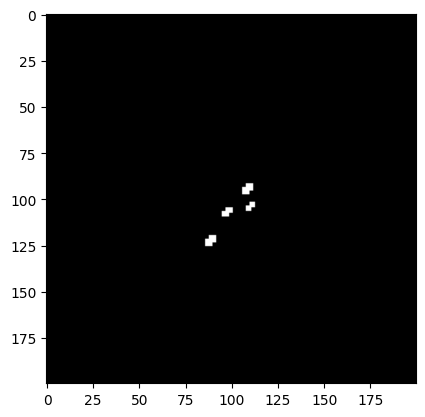

In [598]:
plt.imshow(dataPreprocessed[1], cmap='gray')

In [599]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [600]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [601]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [602]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []


In [603]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [604]:
for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [605]:
for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [606]:
for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

In [607]:
for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [608]:
for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [609]:
for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

In [610]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_1.csv')
hasilEkstrak


,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,BA_10622.jpg,basofil,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,BA_1223.jpg,basofil,0.001106,0.002071,0.001156,0.001667,0.999447,0.998965,0.999422,0.999167,...,0.994083,0.993550,0.997062,0.996568,0.997037,0.996770,0.767867,0.567383,0.757315,0.651796
2,BA_1581.jpg,basofil,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,BA_17648.jpg,basofil,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,BA_18821.jpg,basofil,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,NGS_0837.jpg,neutrofil,0.002010,0.004040,0.002462,0.003333,0.998995,0.997980,0.998769,0.998333,...,0.984961,0.984032,0.992679,0.991630,0.992452,0.991984,0.840258,0.680507,0.804317,0.736418
536,NGS_0843.jpg,neutrofil,0.000302,0.000505,0.000251,0.000404,0.999849,0.999747,0.999874,0.999798,...,0.998644,0.998486,0.999297,0.999192,0.999322,0.999243,0.727122,0.545202,0.772602,0.636162
537,NGS_0861.jpg,neutrofil,0.000302,0.000556,0.000302,0.000455,0.999849,0.999722,0.999849,0.999773,...,0.998293,0.998133,0.999146,0.999015,0.999146,0.999066,0.785563,0.606865,0.785563,0.678344
538,NGS_0873.jpg,neutrofil,0.000704,0.001465,0.000854,0.001111,0.999648,0.999268,0.999573,0.999444,...,0.994634,0.994355,0.997389,0.996997,0.997313,0.997174,0.844092,0.677044,0.810683,0.754999


<Axes: >

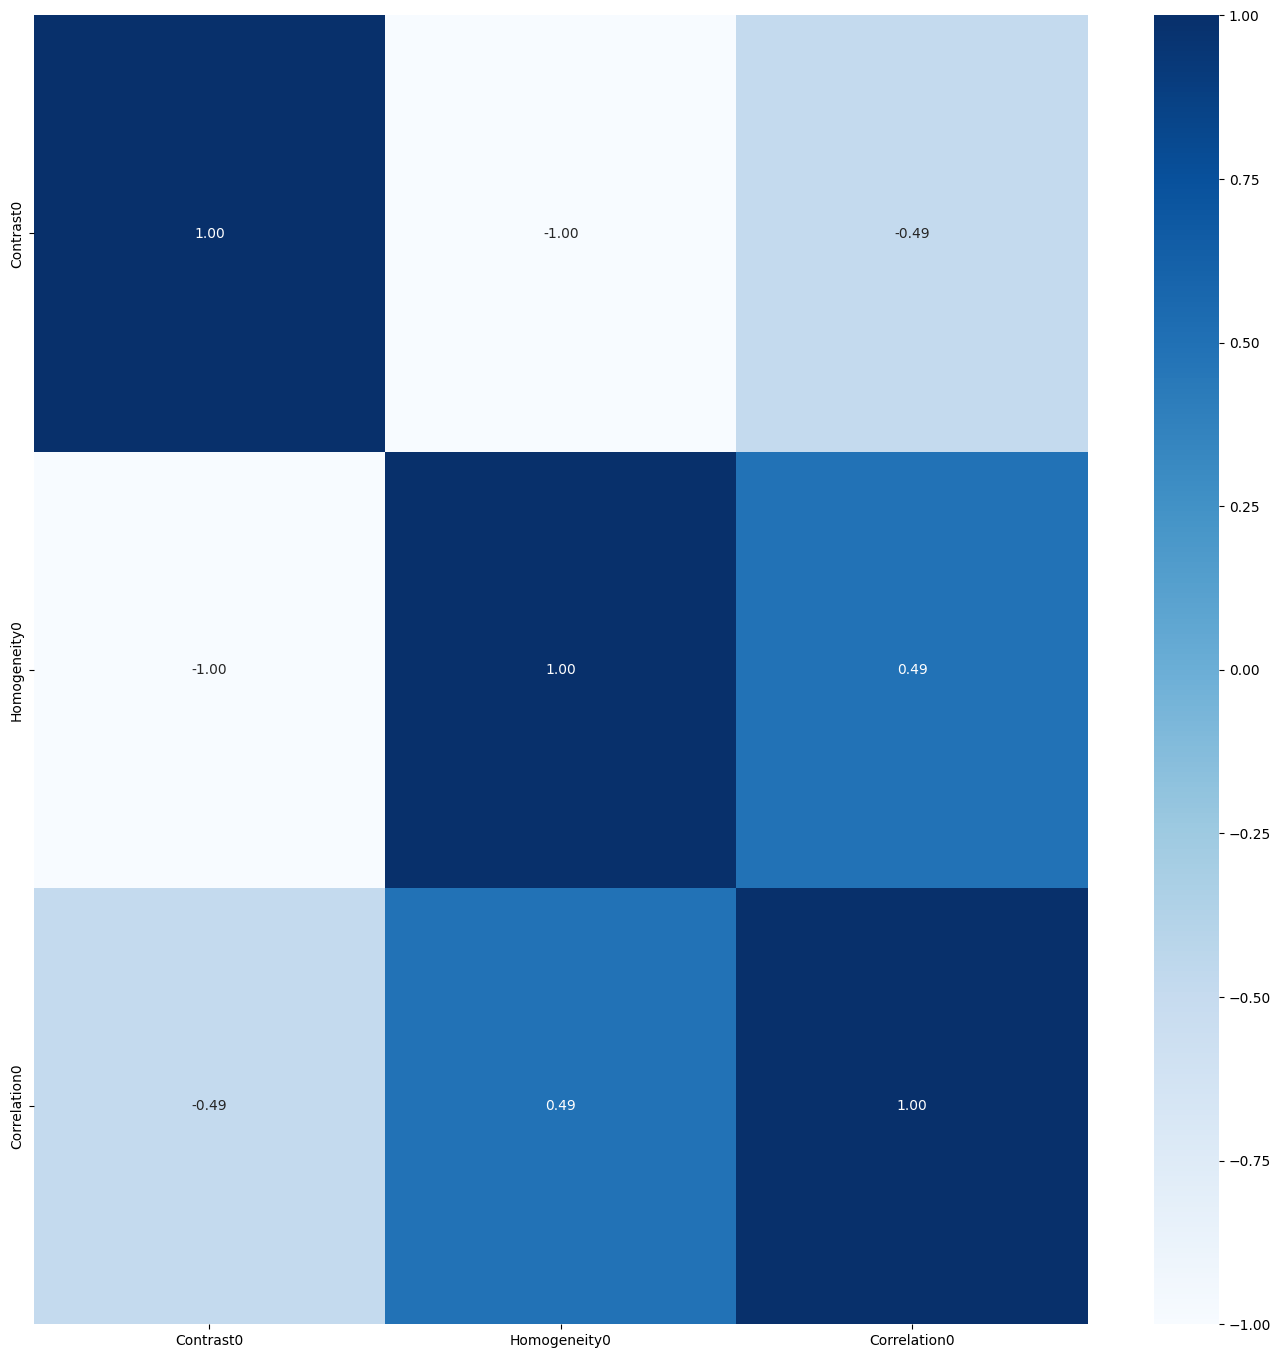

In [611]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

In [612]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(432, 3)
(108, 3)


In [613]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

In [614]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

In [615]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

     basofil       0.64      0.21      0.32        76
   erytoblas       0.32      0.72      0.45        88
     mioblas       0.60      0.60      0.60        91
     monosit       0.45      0.33      0.38        89
   neutrofil       0.91      0.59      0.72        88

    accuracy                           0.50       432
   macro avg       0.59      0.49      0.49       432
weighted avg       0.58      0.50      0.50       432

[[16 48  7  5  0]
 [ 4 63  8 11  2]
 [ 0 24 55  9  3]
 [ 3 46 11 29  0]
 [ 2 13 10 11 52]]
Accuracy: 0.4976851851851852

------Testing Set------
              precision    recall  f1-score   support

     basofil       0.67      0.06      0.11        32
   erytoblas       0.24      0.70      0.35        20
     mioblas       0.19      0.24      0.21        17
     monosit       0.33      0.16      0.21        19
   neutrofil       0.56      0.45      0.50        20

    accuracy   

In [616]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

     basofil       0.50      0.14      0.22        76
   erytoblas       0.28      0.57      0.37        88
     mioblas       0.37      0.42      0.39        91
     monosit       0.35      0.21      0.26        89
   neutrofil       0.64      0.52      0.57        88

    accuracy                           0.38       432
   macro avg       0.43      0.37      0.37       432
weighted avg       0.42      0.38      0.37       432

[[11 46 12  5  2]
 [ 7 50 18 11  2]
 [ 1 23 38 10 19]
 [ 3 47 17 19  3]
 [ 0 13 19 10 46]]
Accuracy: 0.37962962962962965

------Testing Set------
              precision    recall  f1-score   support

     basofil       0.50      0.03      0.06        32
   erytoblas       0.23      0.65      0.34        20
     mioblas       0.12      0.18      0.14        17
     monosit       0.38      0.16      0.22        19
   neutrofil       0.59      0.50      0.54        20

    accuracy 

In [617]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

     basofil       0.33      0.25      0.28        76
   erytoblas       0.45      0.10      0.17        88
     mioblas       0.55      0.47      0.51        91
     monosit       0.29      0.72      0.42        89
   neutrofil       0.80      0.53      0.64        88

    accuracy                           0.42       432
   macro avg       0.48      0.42      0.40       432
weighted avg       0.49      0.42      0.41       432

[[19  3  6 46  2]
 [14  9  7 55  3]
 [ 7  3 43 34  4]
 [12  2  8 64  3]
 [ 6  3 14 18 47]]
Accuracy: 0.4212962962962963

------Testing Set------
              precision    recall  f1-score   support

     basofil       0.38      0.09      0.15        32
   erytoblas       0.00      0.00      0.00        20
     mioblas       0.06      0.06      0.06        17
     monosit       0.20      0.68      0.31        19
   neutrofil       0.44      0.35      0.39        20

    accuracy  

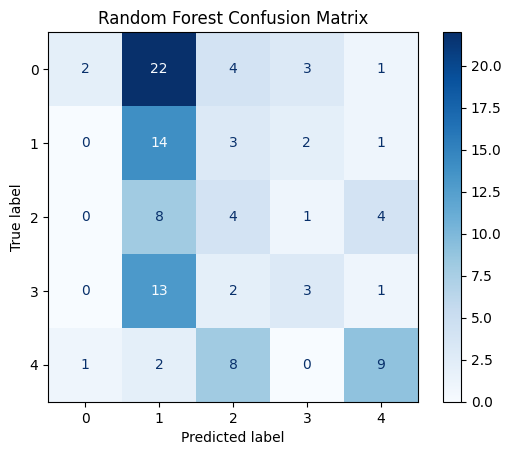

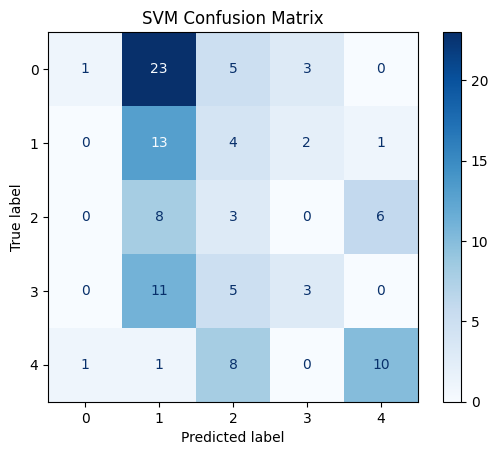

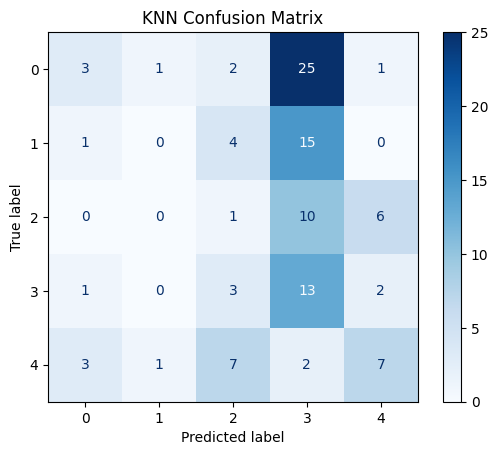

In [618]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")